# Project ARI3205 Interpretable AI for Deep Learning Models *(Part 3.2)*
---

**Name:** Sean David Muscat 

**ID No:** 0172004L

---


# Importing Necessary Libraries

In [7]:
# Check and install required libraries from the libraries.json file
import json

# Read the libraries from the text file
with open('../Libraries/Part3.2_Lib.json', 'r') as file:
    libraries = json.load(file)

# ANSI escape codes for colored output
GREEN = "\033[92m"  # Green text
RED = "\033[91m"    # Red text
RESET = "\033[0m"   # Reset to default color

# Function to check and install libraries
def check_and_install_libraries(libraries):
    for lib, import_name in libraries.items():
        try:
            # Attempt to import the library
            __import__(import_name)
            print(f"[{GREEN}✔{RESET}] Library '{lib}' is already installed.")
        except ImportError:
            # If import fails, try to install the library
            print(f"[{RED}✖{RESET}] Library '{lib}' is not installed. Installing...")
            %pip install {lib}

# Execute the function to check and install libraries
check_and_install_libraries(libraries)

# Import necessary libraries for data analysis and modeling
import warnings                                                                     # Disable warnings
import pandas as pd                                                                 # Data manipulation and analysis                #type: ignore
import numpy as np                                                                  # Numerical computations                        #type: ignore
import matplotlib.pyplot as plt                                                     # Data visualization                            #type: ignore
from sklearn.model_selection import train_test_split                                # Train-test split                              #type: ignore
from tensorflow.keras.models import Sequential                                      # Neural network model                          #type: ignore
from tensorflow.keras.layers import Dense, Input                                    # Neural network layers                         #type: ignore                                                               
from tensorflow.keras.optimizers import Adam                                        # Neural network optimizer                      #type: ignore
from sklearn.preprocessing import StandardScaler,  OneHotEncoder                    # Data scaling                                  #type: ignore
from sklearn.impute import SimpleImputer                                            # Missing value imputation                      #type: ignore
from sklearn.neural_network import MLPClassifier                                    # Neural network classifier                     #type: ignore
# For MMD-Critic
from mmd_critic import MMDCritic                                                                                                    #type: ignore
from mmd_critic.kernels import RBFKernel                                                                                            #type: ignore
from sklearn.decomposition import PCA                                               # For dimensionality reduction                  #type: ignore


# Suppress specific warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names") 
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

[✔] Library 'tensorflow' is already installed.
[✔] Library 'scikit-learn' is already installed.
[✔] Library 'matplotlib' is already installed.
[✔] Library 'seaborn' is already installed.
[✔] Library 'pandas' is already installed.
[✔] Library 'numpy' is already installed.
[✔] Library 'alibi' is already installed.
[✔] Library 'statsmodels' is already installed.
[✔] Library 'mmd-critic' is already installed.


In [8]:
# Define the filenames
train_filename = '../Datasets/Titanic/train.csv'
test_filename = '../Datasets/Titanic/test.csv'
gender_submission_filename = '../Datasets/Titanic/gender_submission.csv'

# Load the datasets
try:
    train_data = pd.read_csv(train_filename)
    test_data = pd.read_csv(test_filename)
    gender_submission_data = pd.read_csv(gender_submission_filename)
    print(f"'{train_filename}' dataset loaded successfully.")
    print(f"'{test_filename}' dataset loaded successfully.")
    print(f"'{gender_submission_filename}' dataset loaded successfully.")
except FileNotFoundError as e:
    print(f"Error: {e.filename} was not found. Please ensure it is in the correct directory.")
    exit()
except pd.errors.EmptyDataError as e:
    print(f"Error: {e.filename} is empty.")
    exit()
except pd.errors.ParserError as e:
    print(f"Error: There was a problem parsing {e.filename}. Please check the file format.")
    exit()

# Dataset insights
print("\nTrain Dataset Overview:")
print(train_data.info())
print("\nTrain Dataset Statistical Summary:")
print(train_data.describe())

print("\nTest Dataset Overview:")
print(test_data.info())
print("\nTest Dataset Statistical Summary:")
print(test_data.describe())

print("\nGender Submission Dataset Overview:")
print(gender_submission_data.info())

'../Datasets/Titanic/train.csv' dataset loaded successfully.
'../Datasets/Titanic/test.csv' dataset loaded successfully.
'../Datasets/Titanic/gender_submission.csv' dataset loaded successfully.

Train Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

Train Dataset Stati

## Feed-Forward Neural Network

In [9]:
# Load the Titanic dataset
train_data = pd.read_csv('../Datasets/Titanic/train.csv')

# Preprocessing
# Separate features and target
y = train_data['Survived']  # Target
X = train_data.drop(columns=['Survived', 'PassengerId', 'Name', 'Ticket', 'Cabin'])  # Features

# Handle categorical variables with one-hot encoding
categorical_features = ['Sex', 'Embarked']
one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
categorical_encoded = one_hot_encoder.fit_transform(X[categorical_features])
categorical_encoded_df = pd.DataFrame(categorical_encoded, columns=one_hot_encoder.get_feature_names_out(categorical_features))

# Drop original categorical columns and append the encoded columns
X = X.drop(columns=categorical_features)
X = pd.concat([X.reset_index(drop=True), categorical_encoded_df.reset_index(drop=True)], axis=1)

# Handle missing values with mean imputation
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Standardize the features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (712, 11)
Test data shape: (179, 11)


In [10]:
# Build the feed-forward neural network
model = Sequential([
    Input(shape=(X_train.shape[1],)),  # Define input shape explicitly
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=1)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Epoch 1/50
18/18 [==============================] - 1s 10ms/step - loss: 0.6789 - accuracy: 0.5923 - val_loss: 0.5875 - val_accuracy: 0.7552
Epoch 2/50
18/18 [==============================] - 0s 3ms/step - loss: 0.5487 - accuracy: 0.7750 - val_loss: 0.4977 - val_accuracy: 0.7832
Epoch 3/50
18/18 [==============================] - 0s 3ms/step - loss: 0.4948 - accuracy: 0.7926 - val_loss: 0.4517 - val_accuracy: 0.7832
Epoch 4/50
18/18 [==============================] - 0s 3ms/step - loss: 0.4670 - accuracy: 0.8014 - val_loss: 0.4337 - val_accuracy: 0.8182
Epoch 5/50
18/18 [==============================] - 0s 3ms/step - loss: 0.4519 - accuracy: 0.8102 - val_loss: 0.4241 - val_accuracy: 0.8252
Epoch 6/50
18/18 [==============================] - 0s 3ms/step - loss: 0.4409 - accuracy: 0.8155 - val_loss: 0.4153 - val_accuracy: 0.8112
Epoch 7/50
18/18 [==============================] - 0s 3ms/step - loss: 0.4289 - accuracy: 0.8278 - val_loss: 0.4136 - val_accuracy: 0.8252
Epoch 8/50
18/18 [=

## Surrogate Model - MLPClassifier

In [11]:
# Train a surrogate model (MLPClassifier)
surrogate_model = MLPClassifier(hidden_layer_sizes=(32,), activation='logistic', random_state=1, max_iter=1000).fit(X_train, y_train)
print('Accuracy (MLPClassifier): ' + str(surrogate_model.score(X_train, y_train)))

Accuracy (MLPClassifier): 0.800561797752809


# Part 3.2

### Set up Prototypes and Criticisms

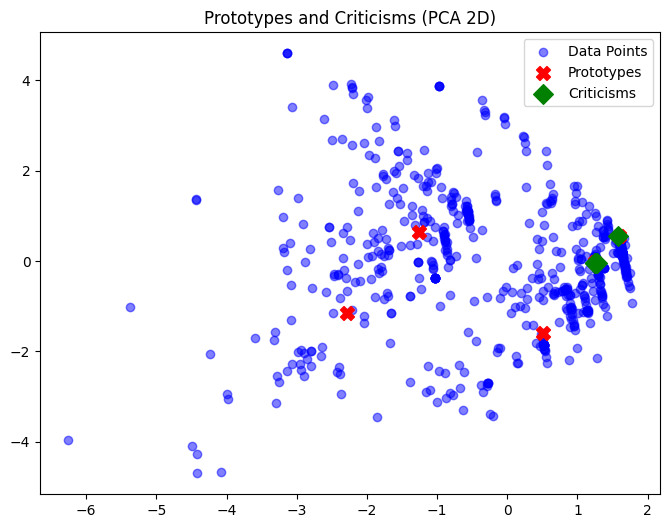

In [12]:
# Cell 5: Integrate MMD-Critic to obtain prototypes and criticisms
# We will use PCA to reduce the dimensionality of X_train to 2D for visualisation.

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_list = X_train_pca.tolist()

# Set the number of prototypes and criticisms you want to extract
n_prototypes = 5
n_criticisms = 5

# Initialise MMD-Critic with two RBF kernels using different bandwidths
critic = MMDCritic(X_list, RBFKernel(1), RBFKernel(0.025))

# Select prototypes
prototypes, _ = critic.select_prototypes(n_prototypes)

# Select criticisms
criticisms, _ = critic.select_criticisms(n_criticisms, prototypes)

# Convert everything back to NumPy arrays for plotting
prototypes = np.array(prototypes)
criticisms = np.array(criticisms)
X_train_pca = np.array(X_list)

# Plot the data points, prototypes, and criticisms
plt.figure(figsize=(8, 6))
plt.scatter(
    X_train_pca[:, 0], 
    X_train_pca[:, 1], 
    c='blue', 
    alpha=0.5, 
    label='Data Points'
)
plt.scatter(
    prototypes[:, 0], 
    prototypes[:, 1], 
    c='red', 
    label='Prototypes', 
    marker='X', 
    s=100
)
plt.scatter(
    criticisms[:, 0], 
    criticisms[:, 1], 
    c='green', 
    label='Criticisms', 
    marker='D', 
    s=100
)
plt.title("Prototypes and Criticisms (PCA 2D)")
plt.legend()
plt.show()


This graph illustrates the result of applying MMD-Critic to identify prototypes and criticisms within the dataset. The blue circles represent the data points once they have been projected into two dimensions using PCA. The points marked with red crosses are the selected prototypes, which serve as representative samples of the dataset’s main patterns or clusters. In contrast, the green diamonds denote the identified criticisms, which highlight data points that are not well explained or captured by the prototypes.

By examining the locations of these prototypes, one can observe the typical examples of the dataset that best characterise the underlying distribution. Conversely, the criticisms provide insight into observations that may be outliers or less typical, suggesting areas where the model’s performance or the dataset’s coverage might warrant further investigation.

### 3.2 b

Prototypes and criticisms are important tools in interpretable AI because they offer a way to understand a dataset and model performance beyond standard metrics. Prototypes highlight examples that capture the most prominent patterns in the dataset, effectively showing what “typical” instances look like. This helps one see how the model generalises by referencing samples deemed highly representative of the underlying data distribution.

Criticisms, on the other hand, draw attention to points that originate from these representative samples, potentially indicating outliers or subsets of data that do not conform to main trends. Identifying such points can prompt further inspection of whether the model handles these “unusual” cases effectively or whether the dataset requires augmentation or refinement. Together, prototypes and criticisms facilitate a more nuanced understanding of model decisions and data coverage, supporting informed decisions about model reliability and fairness.